In [51]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import multinomial
from scipy.special import loggamma, xlogy
from sklearn.decomposition import PCA
from sklearn.cluster import OPTICS, KMeans
from sklearn.mixture import GaussianMixture
from sklearn import metrics
sns.set()
#%matplotlib

In [2]:
def new_z(contigs):
    mean = contigs.mean(axis=0)
    fractions = mean/mean.sum()
    E = (contigs.sum(axis=1) * np.ones(contigs.shape).T).T * fractions
    alt_z = (contigs - E)/np.sqrt(E)
    return alt_z

In [3]:
counts = pd.read_csv("./pca1_tnf.csv")
labels = counts['genome']
true_labels = labels.values
counts = counts.drop('genome',axis=1)
c = counts.values
X = new_z(c)

In [4]:
pca = PCA()
pca.fit(X)
pca_data = pca.transform(X)

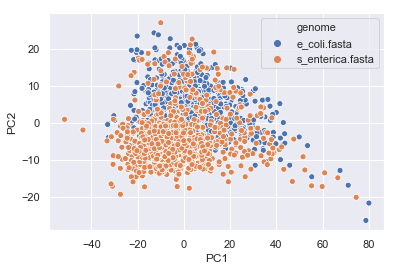

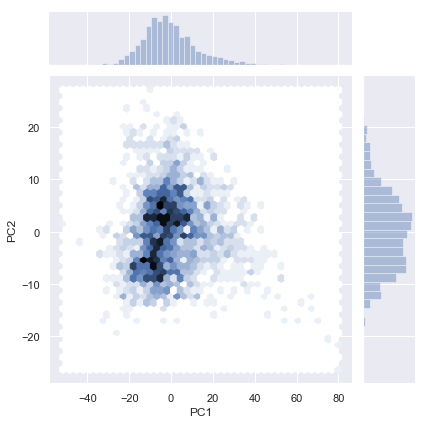

In [5]:
pca_df = pd.DataFrame(pca_data, 
                      columns=['PC'+ str(x+1) for x in range(len(pca.explained_variance_ratio_))])
pca_df['genome']=true_labels

sns.scatterplot(x='PC1', y='PC2', hue='genome', data=pca_df)
sns.jointplot(x='PC1', y='PC2', data=pca_df, kind="hex")

In [6]:
clust = OPTICS(min_samples=50, xi=0.001, min_cluster_size=.05)
clust.fit(pca_data[:,:20])

OPTICS(algorithm='auto', cluster_method='xi', eps=None, leaf_size=30,
       max_eps=inf, metric='minkowski', metric_params=None,
       min_cluster_size=0.05, min_samples=50, n_jobs=None, p=2,
       predecessor_correction=True, xi=0.001)

In [7]:
space = np.arange(len(pca_data))
reachability = clust.reachability_[clust.ordering_]
clusters = set(labels)
number_of_clusters = len(clusters)

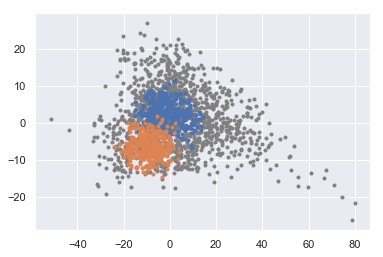

In [8]:
noise = pca_data[clust.labels_ == -1]
X1 = pca_data[clust.labels_ == 0]
X2 = pca_data[clust.labels_ == 1]
plt.plot(noise[:,0], noise[:,1], '.', color='gray')
plt.plot(X1[:,0], X1[:,1], '.')
plt.plot(X2[:,0], X2[:,1], '.')
plt.show()

In [9]:
gmm = GaussianMixture(n_components=number_of_clusters, covariance_type='full')
labels = gmm.fit_predict(pca_data[:,:4])

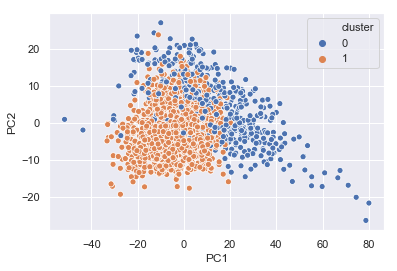

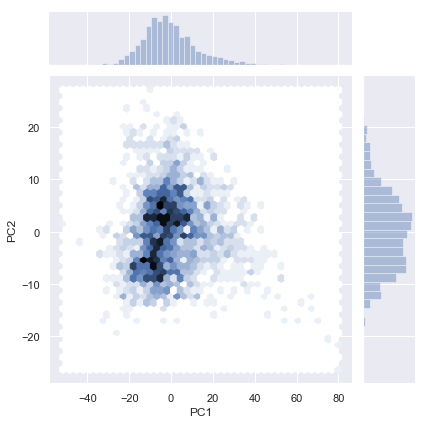

In [10]:
pca_df = pd.DataFrame(pca_data, 
                      columns=['PC'+ str(x+1) for x in range(len(pca.explained_variance_ratio_))])
pca_df['cluster']=labels

sns.scatterplot(x='PC1', y='PC2', hue='cluster', data=pca_df)
sns.jointplot(x='PC1', y='PC2', data=pca_df, kind="hex")

## Contamination levels

In [11]:
counts = pd.read_csv("./s_marcescens_counts.csv")
counts = counts.loc[counts['contamination'] == 0.2]
counts.head()
labels = counts['contamination']
labels = labels.values
counts = counts.drop('contamination',axis=1)
c = counts.values
X = new_z(c)

In [12]:
pca = PCA()
pca.fit(X)
pca_data = pca.transform(X)

In [24]:
clust = OPTICS(min_samples=50, xi=0.001, min_cluster_size=.05)
clust.fit(pca_data[:,:20])

OPTICS(algorithm='auto', cluster_method='xi', eps=None, leaf_size=30,
       max_eps=inf, metric='minkowski', metric_params=None,
       min_cluster_size=0.05, min_samples=50, n_jobs=None, p=2,
       predecessor_correction=True, xi=0.001)

In [35]:
space = np.arange(len(pca_data))
reachability = clust.reachability_[clust.ordering_]
clusters = set(clust.labels_)
if -1 in clusters:
    clusters.remove(-1)
number_of_clusters = len(clusters)

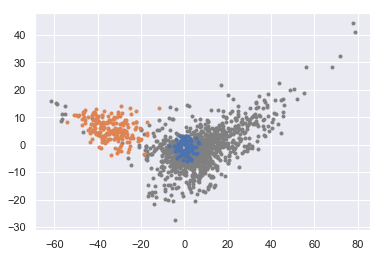

In [36]:
noise = pca_data[clust.labels_ == -1]
X1 = pca_data[clust.labels_ == 0]
X2 = pca_data[clust.labels_ == 1]
plt.plot(noise[:,0], noise[:,1], '.', color='gray')
plt.plot(X1[:,0], X1[:,1], '.')
plt.plot(X2[:,0], X2[:,1], '.')
plt.show()

In [42]:
tmp = []
for c in clusters:
    tmp.append(pca_data[clust.labels_ == c].mean(axis=0))

initial = np.array(tmp)

In [43]:
#Fit K-means
km = KMeans(n_clusters=number_of_clusters, init=initial[:,:8])
km_labels = km.fit_predict(pca_data[:,:8])

/home/kuba/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:969: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)


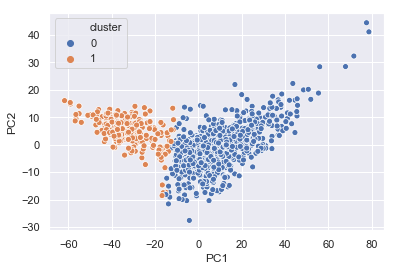

In [44]:
pca_df = pd.DataFrame(pca_data, 
                      columns=['PC'+ str(x+1) for x in range(len(pca.explained_variance_ratio_))])
pca_df['cluster']=km_labels

sns.scatterplot(x='PC1', y='PC2', hue='cluster', data=pca_df)

In [45]:
gmm = GaussianMixture(n_components=number_of_clusters, covariance_type='full')

# Initialize without noise
tmp = []
for c in clusters:
    tmp.append(pca_data[clust.labels_ == c])

#initial = np.vstack(tmp)
gmm.fit(initial[:,:8])
gmm.set_params(warm_start=True)
labels = gmm.fit_predict(pca_data[:,:8])

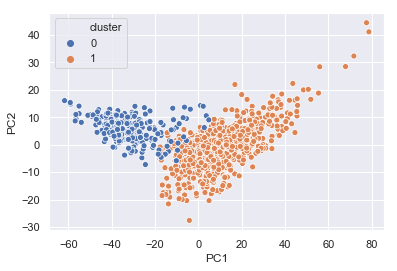

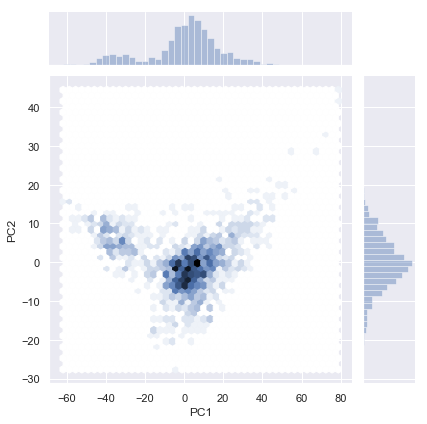

In [46]:
pca_df = pd.DataFrame(pca_data, 
                      columns=['PC'+ str(x+1) for x in range(len(pca.explained_variance_ratio_))])
pca_df['cluster']=labels

sns.scatterplot(x='PC1', y='PC2', hue='cluster', data=pca_df)
sns.jointplot(x='PC1', y='PC2', data=pca_df, kind="hex")

In [21]:
cluster_counts = []
for i in range(len(set(labels))):
    cluster_counts.append(len(labels[labels == i]))

In [22]:
main = max(cluster_counts)
est_contamination = (sum(cluster_counts) - main)/sum(cluster_counts)
est_contamination

0.34528448947778645

## Contamination all

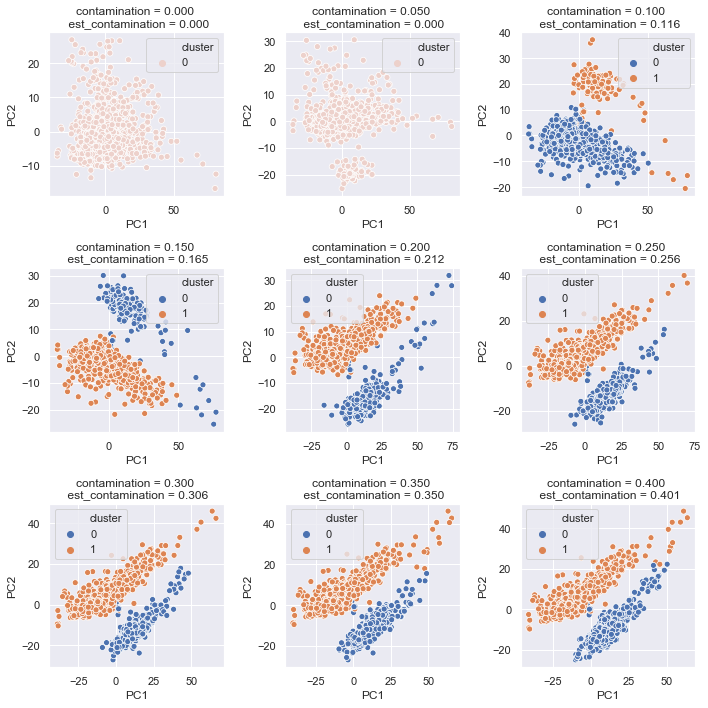

In [53]:
plt.figure(figsize=(10,10))
i=1
for n in [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]:
    counts = pd.read_csv("./v_cholerae_conts.csv")
    counts = counts.loc[counts['contamination'] == n]
    counts.head()
    labels = counts['contamination']
    labels = labels.values
    counts = counts.drop('contamination',axis=1)
    c = counts.values
    X = new_z(c)

    pca = PCA()
    pca.fit(X)
    pca_data = pca.transform(X)
    
    clust = OPTICS(min_samples=50, xi=0.001, min_cluster_size=.05)
    clust.fit(pca_data[:,:20])
    
    space = np.arange(len(pca_data))
    reachability = clust.reachability_[clust.ordering_]
    clusters = set(clust.labels_)
    if -1 in clusters:
        clusters.remove(-1)
    number_of_clusters = len(clusters)
    
    """
    gmm = GaussianMixture(n_components=number_of_clusters, covariance_type='full')

    
    tmp = []
    for c in clusters:
        tmp.append(pca_data[clust.labels_ == c])

    initial = np.array(tmp)
    initial_m = np.zeros((len(tmp), 256))
    for x in range(len(tmp)):
        initial_m[x] = initial[0].mean(axis=0)


    gmm = GaussianMixture(n_components=number_of_clusters, 
                          covariance_type='full', means_init=initial_m[:,:4]) 

    labels = gmm.fit_predict(pca_data[:,:4])
    """
    
    gmm = GaussianMixture(n_components=number_of_clusters, covariance_type='full')
    
    # Initialize without noise
    """
    tmp = []
    for c in clusters:
        tmp.append(pca_data[clust.labels_ == c])

    initial = np.vstack(tmp)
    """
    tmp = []
    for c in clusters:
        tmp.append(pca_data[clust.labels_ == c].mean(axis=0))
    
    if number_of_clusters>1:
        initial = np.array(tmp)
    
        gmm.fit(initial[:,:8])
        gmm.set_params(warm_start=True)
    
    labels = gmm.fit_predict(pca_data[:,:8])
    
    cluster_counts = []
    for j in range(len(set(labels))):
        cluster_counts.append(len(labels[labels == j]))
    
    
    main = max(cluster_counts)
    est_contamination = (sum(cluster_counts) - main)/sum(cluster_counts)
    

    plt.subplot(3,3,i)
    plt.title('contamination = %4.3f \n est_contamination = %4.3f' % (n, est_contamination))
    pca_df = pd.DataFrame(pca_data, 
                      columns=['PC'+ str(x+1) for x in range(len(pca.explained_variance_ratio_))])
    pca_df['cluster']=labels

    sns.scatterplot(x='PC1', y='PC2', hue='cluster', data=pca_df)
    #sns.jointplot(x='PC1', y='PC2', data=pca_df, kind="hex")
    
    
    i += 1

plt.tight_layout()
plt.show()

### Notes

Contamination estimation do not work properly for small contamination values and closely related organisms. We can try to correct for it using linear model

For small contamination values large variance in at least one of the clusters is observed

For closely related species centers of cluster are close to each other

So we can think about something like:

cont = a * est_contamination + b * variance + c * distance between centers of clusters

## No optics step, model selection with BIC

In [ ]:
plt.figure(figsize=(10,10))
i=1
for n in [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]:
    counts = pd.read_csv("./v_cholerae_conts.csv")
    counts = counts.loc[counts['contamination'] == n]
    counts.head()
    labels = counts['contamination']
    labels = labels.values
    counts = counts.drop('contamination',axis=1)
    c = counts.values
    X = new_z(c)

    pca = PCA()
    pca.fit(X)
    pca_data = pca.transform(X)
    

    lowest_bic = np.infty
    bic = []
    n_components_range = range(1, 3)

    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = GaussianMixture(n_components=n_components, covariance_type='full')
        gmm.fit(pca_data[:,:4])
        bic.append(gmm.bic(pca_data[:,:4]))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm

    bic = np.array(bic)

    clf = best_gmm
    
    labels = clf.predict(pca_data[:,:4])
    
    cluster_counts = []
    for j in range(len(set(labels))):
        cluster_counts.append(len(labels[labels == j]))
    
    
    main = max(cluster_counts)
    est_contamination = (sum(cluster_counts) - main)/sum(cluster_counts)
    

    plt.subplot(3,3,i)
    plt.title('contamination = %4.3f \n est_contamination = %4.3f' % (n, est_contamination))
    pca_df = pd.DataFrame(pca_data, 
                      columns=['PC'+ str(x+1) for x in range(len(pca.explained_variance_ratio_))])
    pca_df['cluster']=labels

    sns.scatterplot(x='PC1', y='PC2', hue='cluster', data=pca_df)
    #sns.jointplot(x='PC1', y='PC2', data=pca_df, kind="hex")
    
    
    i += 1

plt.tight_layout()
plt.show()